In [ ]:
import tensorflow as tf
from collections import OrderedDict

class Dataset:
    def __init__(self, batch_size, dataset_path, dataset_info_path, shuffle_buffer_size=0):
        self._batch_size = batch_size
        self._shuffle_buffer_size = shuffle_buffer_size
        self._dataset_path = dataset_path
        with open(dataset_info_path, 'r') as dataset_info:
            self.examples_num = int(dataset_info.readline())
            self.scale_factor = int(dataset_info.readline())
            self.input_info = OrderedDict()
            for line in dataset_info.readlines():
                items = line.split(',')
                self.input_info[items[0]] = [int(dim) for dim in items[1:]]

    def _parse_tf_example(self, example_proto):
        features = dict([(key, tf.io.FixedLenFeature([], tf.string)) for key, _ in self.input_info.items()])
        parsed_features = tf.io.parse_single_example(example_proto, features=features)

        return [tf.reshape(tf.cast(tf.io.decode_raw(parsed_features[key], tf.uint8), tf.float32), value)
                for key, value in self.input_info.items()]
    
    def get_data(self,epoch=None):
        dataset = tf.data.TFRecordDataset(self._dataset_path)
        dataset = dataset.map(self._parse_tf_example,num_parallel_calls=tf.data.AUTOTUNE) 
        #dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        dataset = dataset.batch(self._batch_size,drop_remainder=True)
        return dataset

In [ ]:
batch_size = 32
num_steps_in_epoch = 67276 // batch_size 
train_dataset_path = 'datasets/train/dataset.tfrecords'
train_dataset_info_path = 'datasets/train/dataset_info.txt'
shuffle_buffer_size = 0 

#batch_size = 32
#num_steps_in_epoch = 443565 // batch_size 
#train_dataset_path = 'datasets/train-2x/dataset.tfrecords'
#train_dataset_info_path = 'datasets/train-2x/dataset_info.txt'
#shuffle_buffer_size = 0

train_dataset = Dataset(batch_size,
        train_dataset_path,
        train_dataset_info_path,
        shuffle_buffer_size)

In [ ]:
print(train_dataset.scale_factor)
print(train_dataset.examples_num)

In [ ]:
dataset = train_dataset.get_data(epoch=1)
#dataset = dataset.map(lambda x0,x1,x2,y: (x1/255.0,y/255.0))

for i in dataset:
    print(i[0].shape)

# Work with tf.data

In [39]:
import tensorflow as tf

import numpy as np
import IPython.display as display

In [40]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [41]:
cat_in_snow  = tf.keras.utils.get_file(
    '320px-Felis_catus-cat_on_snow.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')

williamsburg_bridge = tf.keras.utils.get_file(
    '194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

In [42]:
print(cat_in_snow)

/home/joao/.keras/datasets/320px-Felis_catus-cat_on_snow.jpg


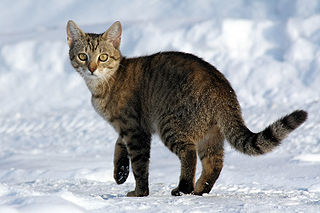

In [43]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

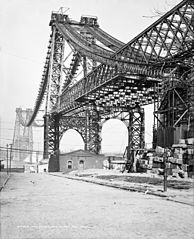

In [44]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg">From Wikimedia</a>'))

In [45]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [46]:
type(image_labels)

dict

In [47]:
image_labels[cat_in_snow]

0

In [56]:
image_string = open(cat_in_snow, 'rb').read()
type(image_string)

bytes

In [48]:
# This is an example, just using the cat image.
image_string = open(cat_in_snow, 'rb').read()

label = image_labels[cat_in_snow]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
  image_shape = tf.io.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:20]:
  print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
    }
  }
  feature {
    key: "image_raw"
    value {
...


In [49]:
str(image_example(image_string, label)).split('\n')[:15]

['features {',
 '  feature {',
 '    key: "depth"',
 '    value {',
 '      int64_list {',
 '        value: 3',
 '      }',
 '    }',
 '  }',
 '  feature {',
 '    key: "height"',
 '    value {',
 '      int64_list {',
 '        value: 213',
 '      }']

In [50]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [51]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

<class 'bytes'>


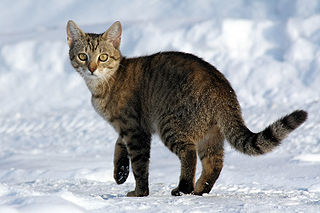

<class 'bytes'>


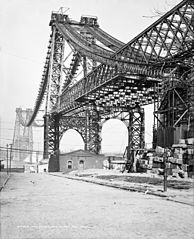

In [65]:
for image_features in parsed_image_dataset:
    image_raw = image_features['image_raw'].numpy()
    print(type(image_raw))
    display.display(display.Image(data=image_raw))
    

# Test with dataset

In [84]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [85]:
train_dataset_path = 'datasets/test/dataset.tfrecords'
train_dataset_info_path = 'datasets/test/dataset_info.txt'

In [86]:
raw_dataset = tf.data.TFRecordDataset(train_dataset_path)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [87]:
# Create a dictionary describing the features.
feature_description = {
    'lr0': tf.io.FixedLenFeature([], tf.string),
    'lr1': tf.io.FixedLenFeature([], tf.string),
    'lr2': tf.io.FixedLenFeature([], tf.string),
    'hr': tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset = raw_dataset.map(_parse_image_function)
parsed_dataset

<MapDataset shapes: {hr: (), lr0: (), lr1: (), lr2: ()}, types: {hr: tf.string, lr0: tf.string, lr1: tf.string, lr2: tf.string}>

In [111]:
count=0
imgs_lr = []
imgs_hr = []
for image in parsed_dataset:
    img_lr = tf.reshape(tf.cast(tf.io.decode_raw(image['lr1'], tf.uint8), tf.float32),(540,960,1))
    imgs_lr.append(img_lr.numpy())
    img_hr = tf.reshape(tf.cast(tf.io.decode_raw(image['hr'], tf.uint8), tf.float32),(2160,3840,1))
    imgs_hr.append(img_hr.numpy())
    count+=1 
    if count==100:
        break
print(count)

100


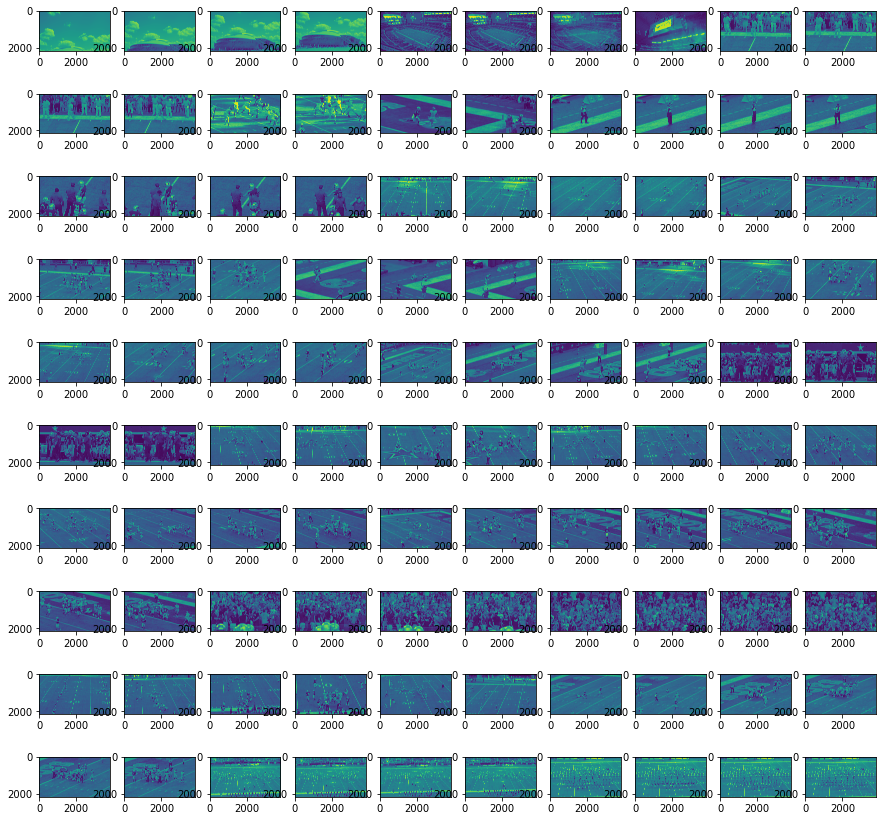

In [112]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10,10, figsize=(15,15))

for i,ax in enumerate(axes.flat):
    ax.imshow(imgs_hr[i])

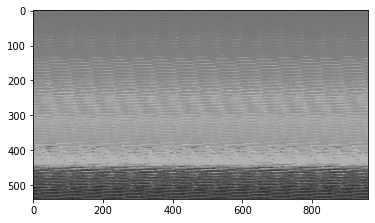

In [113]:
plt.imshow(imgs_lr[1], cmap='gray', vmin=0, vmax=255)

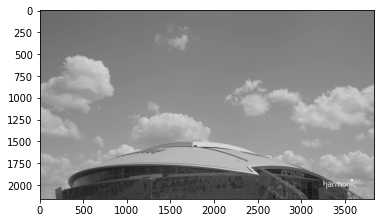

In [114]:
plt.imshow(imgs_hr[1], cmap='gray', vmin=0, vmax=255)